In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

### Загрузка данных и первичный анализ

In [2]:
# Загрузка csv
df = pd.read_csv('S06-hw-dataset-03.csv')

In [3]:
# Минимальные сведения о датасете
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f20,f21,f22,f23,f24,f25,f26,f27,f28,target
0,1,-2.721419,0.652294,1.867234,-0.245331,-0.241182,-0.195509,1.180193,-0.724816,1.804165,...,0.042851,-0.153232,1.566167,-1.516125,-1.586857,-3.998937,-1.308459,2.155125,1.992519,0
1,2,-4.191520,-0.647731,-0.881929,-0.968159,3.530725,-4.858592,0.240979,-0.714017,0.285769,...,-1.170056,0.631661,1.277915,-0.464432,1.927986,6.034154,0.149833,4.861592,-3.547303,0
2,3,-0.582739,0.415128,-4.205613,-0.320853,0.313570,-2.655451,2.215387,1.492222,-0.516727,...,0.083281,-0.757912,5.672669,-0.283472,0.275362,-0.988055,0.940883,-3.050749,-0.703865,1
3,4,-1.766082,1.253523,1.610804,0.466067,3.837868,-3.564073,-1.831031,1.066265,-0.198636,...,-0.674648,1.780285,-4.718432,0.711573,1.705610,6.474380,-1.690537,8.687735,-2.799399,0
4,5,-2.157834,-1.361285,-0.917199,0.937285,0.408551,-0.062032,-0.480196,-0.554454,-1.026434,...,-0.096277,0.212875,1.710699,2.476220,0.669305,3.166072,-0.718493,3.630457,0.083986,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      15000 non-null  int64  
 1   f01     15000 non-null  float64
 2   f02     15000 non-null  float64
 3   f03     15000 non-null  float64
 4   f04     15000 non-null  float64
 5   f05     15000 non-null  float64
 6   f06     15000 non-null  float64
 7   f07     15000 non-null  float64
 8   f08     15000 non-null  float64
 9   f09     15000 non-null  float64
 10  f10     15000 non-null  float64
 11  f11     15000 non-null  float64
 12  f12     15000 non-null  float64
 13  f13     15000 non-null  float64
 14  f14     15000 non-null  float64
 15  f15     15000 non-null  float64
 16  f16     15000 non-null  float64
 17  f17     15000 non-null  float64
 18  f18     15000 non-null  float64
 19  f19     15000 non-null  float64
 20  f20     15000 non-null  float64
 21  f21     15000 non-null  float64
 22

In [5]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f20,f21,f22,f23,f24,f25,f26,f27,f28,target
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,-0.840416,-0.011530,0.755463,0.008092,-0.246559,0.992538,-0.004599,-0.005366,0.011024,...,0.008801,0.004798,-0.060611,-0.008095,0.002397,0.699377,-0.001170,1.380216,0.150765,0.612600
std,4330.271354,1.785432,1.007374,3.663136,0.996556,2.216202,3.943110,2.113607,1.001960,1.006309,...,0.988931,0.999959,3.747823,0.994912,0.990567,3.801468,0.996588,3.929134,2.005847,0.740016
min,1.000000,-8.199174,-4.100091,-13.591257,-3.992807,-8.243563,-14.950758,-8.522298,-3.768197,-3.791645,...,-3.612116,-4.150852,-15.977469,-3.664246,-3.857890,-16.273835,-4.536600,-12.105957,-8.300728,0.000000
25%,3750.750000,-2.029608,-0.686265,-1.593729,-0.674039,-1.738188,-1.580544,-1.380091,-0.673001,-0.661451,...,-0.674236,-0.669654,-2.517892,-0.676471,-0.661098,-1.842677,-0.668133,-1.339314,-1.235425,0.000000
50%,7500.500000,-0.855943,-0.010454,0.744919,0.009431,-0.203512,1.110848,0.134466,-0.003663,0.004158,...,0.020916,0.010701,0.019034,-0.001622,0.001807,0.780608,-0.007763,1.108728,0.137089,0.000000
75%,11250.250000,0.313482,0.674347,3.057234,0.677459,1.254102,3.700201,1.443666,0.662753,0.683465,...,0.681036,0.676786,2.521745,0.659456,0.663270,3.297387,0.676626,3.869991,1.524830,1.000000
max,15000.000000,7.338969,4.418126,17.965154,3.887820,8.542916,15.618988,7.575797,3.698010,3.963730,...,3.497004,3.828639,12.661894,4.214633,4.378893,17.152063,3.618447,18.906060,8.007400,2.000000


In [7]:
# Распределение признака target
df['target'].value_counts(normalize=True)

target
0    0.542533
1    0.302333
2    0.155133
Name: proportion, dtype: float64

Из результата df.info() можем наблюдать, что пропусков в датасете нет, а типы данных всех столбцов признаков (т.е. кроме id и target) являются float64. id и target - int64.

In [9]:
# Определение признаков и таргета
y = df['target']
X = df.drop(columns=['id', 'target'])

### Train/Test-сплит и воспроизводимость

In [14]:
# Разделение данныч на train/test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19, stratify=y)

Стратификация нужна, чтобы распределение классов сохранялось в обучающей и тестовой выборках. Фиксированный seed, в свою очередь, обеспечивает воспроизводимость (полностью повторяемый результат при каждом запуске кода), таким образом становится возможно честное сравненить разные алгоритмы на одинаковых данных.

### Baseline’ы

In [27]:
# Бейзлайн-модель на основе DummyClassifier
dm = DummyClassifier(strategy="stratified", random_state=19)
dm.fit(X_train, y_train)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'stratified'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",19
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


In [69]:
# Оценка метрик для DummyClassifier
y_pred_dm = dm.predict(X_test)
y_pred_proba_dm = dm.predict_proba(X_test)
# оценка Accuracy
accuracy_dm = accuracy_score(y_test, y_pred_dm)
# оценка f1_macro
f1_dm = f1_score(y_test, y_pred_dm, average='macro')
# оценка ROC-AUC
roc_auc_dm = roc_auc_score(y_test, y_pred_proba_dm, multi_class='ovr')

print(f'Accuracy: {accuracy_dm}')
print(f'F1: {accuracy_dm}')
print(f'ROC-AUC:  {roc_auc_dm}')

Accuracy: 0.415
F1: 0.415
ROC-AUC:  0.5067397796105954


In [70]:
# Построение Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

In [71]:
# Подбор параметра регуляризации C
c_values = [0.01, 0.1, 1.0, 10.0]

for C in c_values:
    pipe.set_params(logreg__C=C)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    print(f"C = {C}: accuracy = {score:.8f}")

C = 0.01: accuracy = 0.72133333
C = 0.1: accuracy = 0.72200000
C = 1.0: accuracy = 0.72200000
C = 10.0: accuracy = 0.72200000


In [73]:
# Обучение модели с выбранным параметром C и оценка
pipe.set_params(logreg__C=0.1)
pipe.fit(X_train, y_train)
y_pred_lg = pipe.predict(X_test)
y_pred_proba_lg = pipe.predict_proba(X_test)

# оценка Accuracy
accuracy_lg = accuracy_score(y_test, y_pred_lg)
# оценка f1_macro
f1_lg = f1_score(y_test, y_pred_lg, average='macro')
# оценка ROC-AUC
roc_auc_lg = roc_auc_score(y_test, y_pred_proba_lg, multi_class='ovr')

print(f"Accuracy: {accuracy_lg}")
print(f"F1: {f1_lg}")
print(f"ROC-AUC:  {roc_auc_lg}")

Accuracy: 0.722
F1: 0.659966031037906
ROC-AUC:  0.8427919367389375


In [77]:
# Сравнение бейзлайна и логистической регрессии
results = pd.DataFrame({
    'Model': ['Baseline (Stratified)', 'Logistic Regression'],
    'Accuracy': [accuracy_dm, accuracy_lg],
    'F1': [f1_dm, f1_lg],
    'ROC-AUC': [roc_auc_dm, roc_auc_lg]})

results

,Model,Accuracy,F1,ROC-AUC
0,Baseline (Stratified),0.415,0.346775,0.506740
1,Logistic Regression,0.722,0.659966,0.842792


В результате анализа метрик двух бейзлайн моделей, можно утверждать, что модель на основе логистической регрессии, постороенная через Pipeline, выдает значительно лучший результат в сравнении с DummyClassifier.

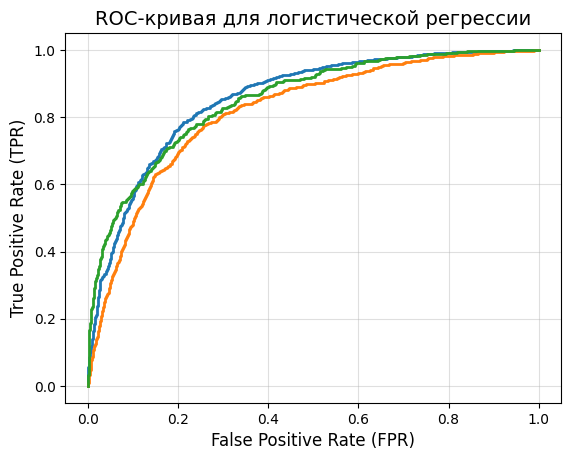

In [56]:
# Построение графика ROC-кривой (для мультикласса)
n_classes = 3
y_true_bin = label_binarize(y_test, classes=y.unique())
for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba_lg[:, i])
        auc_score = roc_auc_score(y_test, y_pred_proba_lg, multi_class='ovr')
        plt.plot(fpr, tpr, lw=2, 
                 label=f'{y.unique()[i]} (AUC={auc_score:.3f})')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-кривая для логистической регрессии', fontsize=14)
plt.grid(alpha=0.4)

# Сохранение графика
plt.savefig('artifacts/figures/roc.png')

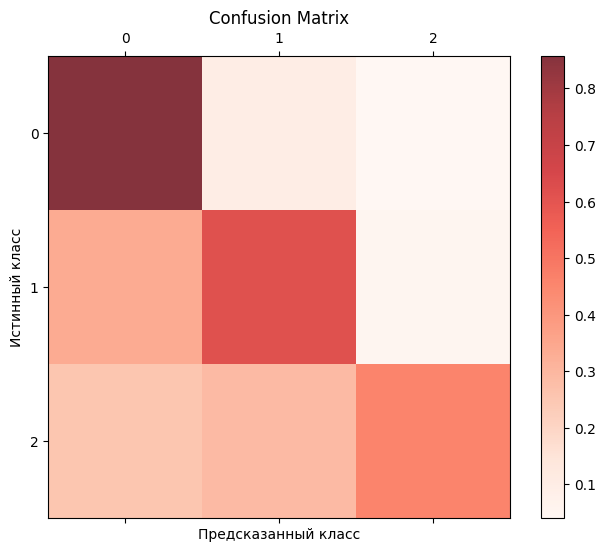

In [68]:
cm = confusion_matrix(y_test, y_pred_lg)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.8)
plt.colorbar(cax)
plt.title('Confusion Matrix')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.savefig('artifacts/figures/confusion.png')

### Модели недели 6

#### Decision Tree Classifier

In [92]:
# Обучение модели Decision Tree Classifier с подбором гиперпараметров через GridSearchCV
dt_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_leaf': [1, 2, 3, 5, 10, 20]
}

dt = DecisionTreeClassifier(random_state=19)

# GridSearchCV
dt_grid = GridSearchCV(
    estimator=dt,
    param_grid=dt_params,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train, y_train)

print(f"\nЛучшие параметры: {dt_grid.best_params_}")
print(f"Лучшая точность (CV): {dt_grid.best_score_:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 5}
Лучшая точность (CV): 0.7371


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=19)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed

In [99]:
best_model = dt_grid.best_estimator_
y_pred = best_model.predict(X_test)

# Оценка лучшей модели Decision Tree Classifier
accuracy_dt = accuracy_score(y_test, y_pred_lg)
f1_dt = f1_score(y_test, y_pred, average='macro')
print(f'Decision Tree Classifier Accuracy: {accuracy_dt}')
print(f'Decision Tree Classifier F1: {test_f1}')

Decision Tree Classifier Accuracy: 0.722
Decision Tree Classifier F1: 0.7290730341838492
